In [1]:
from tokenizers import Tokenizer
from datasets import load_dataset
from transformers import AutoModelForCausalLM,AutoTokenizer,AutoModelForMaskedLM,AutoModelForSeq2SeqLM,BertForMaskedLM,RobertaForMaskedLM
from collections import Counter
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
from collections import defaultdict
from core_functions import *
from core_functions import access_token
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score
import torch
import torch.nn.functional as F
import warnings
import gc
import sentencepiece as spm
from torch.utils.data import DataLoader, Dataset
warnings.filterwarnings("ignore", category=UserWarning)

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version 

## Load Existing Tokenizers

In [2]:
gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it", trust_remote_code=True, token=access_token)
gemma_vocab = list(gemma_tokenizer.vocab)
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_vocab = list(bert_tokenizer.vocab)
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
xlmr_vocab = list(xlmr_tokenizer.vocab)
mt5_tokenizer = AutoTokenizer.from_pretrained("google/mt5-base")
mt5_vocab = list(mt5_tokenizer.vocab)
mbart_tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
mbart_vocab = list(mbart_tokenizer.vocab.keys())
indic_bert = AutoTokenizer.from_pretrained("ai4bharat/indic-bert",use_auth_token=access_token)
indic_bert_vocab = list(indic_bert.vocab.keys())

/opt/conda/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:935: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


## Multilingual Morphscore calculation

In [3]:
ds = load_dataset("catherinearnett/morphscore")
morphScore_df = ds['train'].to_pandas()
languages = ['tam_taml', 'tur_latn', 'spa_latn','eng_latn', 'arb_latn','deu_latn','fra_latn','fin_latn','nld_latn']
features_to_select = ['wordform', 'stem', 'following_part']

dfs = {}
for lang in languages:
    dfs[lang] = morphScore_df[morphScore_df['language'] == lang][features_to_select]

In [4]:
Morph_data_Tamil = dfs['tam_taml']
Morph_data_English = dfs['eng_latn'][:5000]
Morph_data_German = dfs['deu_latn'][:5000]
Morph_data_Spanish = dfs['spa_latn'][:5000]
Morph_data_Turkish = dfs['tur_latn'][:5000]
Morph_data_French = dfs['fra_latn'][:5000]
Morph_data_Arabic = dfs['arb_latn'][:5000]
Morph_data_Finnish = dfs['fin_latn'][:5000]
Morph_data_Dutch = dfs['nld_latn'][:5000]

In [5]:
def get_boundaries(segmentation):
    boundaries = set()
    pos = 0
    for token in segmentation[:-1]:
        pos += len(token)
        boundaries.add(pos)
    return boundaries

def creutz_linden_f1(gold_segmentation, tokenizer_segmentation):
    gold_boundaries = get_boundaries(gold_segmentation)
    token_boundaries = get_boundaries(tokenizer_segmentation)
    if len(tokenizer_segmentation) == 1:
        tp = 1
        fp = 0
        fn = 0
    else:
        tp = len(gold_boundaries.intersection(token_boundaries))
        fp = len(token_boundaries - gold_boundaries)
        fn = len(gold_boundaries - token_boundaries)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    accuracy = (tp / (tp + fn)) if (tp + fn) > 0 else 0.0 
    return precision, recall, f1, accuracy

def compute_morphological_alignment(df, tokenizer_columns):
    results = {tok: {'precision': [], 'recall': [], 'f1': [], 'accuracy': [], 'length':[], 'total': []} for tok in tokenizer_columns}
    for idx, row in df.iterrows():
        gold = [row['stem'], row['following_part']]

        for tok in tokenizer_columns:
            tokens = row[tok]
            p, r, f1, acc = creutz_linden_f1(gold, tokens)
            results[tok]['precision'].append(p)
            results[tok]['recall'].append(r)
            results[tok]['f1'].append(f1)
            results[tok]['accuracy'].append(acc)
            results[tok]['total'].append(1)
            results[tok]['length'].append(len(tokens))
    stats = {}
    for tok, vals in results.items():
        total = sum(vals['total'])
        avg_p = sum(vals['precision']) / len(vals['precision'])
        avg_r = sum(vals['recall']) / len(vals['recall'])
        avg_f1 = sum(vals['f1']) / len(vals['f1'])
        avg_acc = sum(vals['accuracy']) / len(vals['accuracy'])      
        stats[tok] = {'Precision': avg_p, 'Recall': avg_r, 'F1 Score': avg_f1, 'Accuracy': avg_acc, 'Total' : total}

    return pd.DataFrame(stats).T

In [6]:
tokenizer_dict = {
    "Gemma": gemma_tokenizer,
    "mBERT": bert_tokenizer,
    "IndicBERT": indic_bert,
    "XLMR": xlmr_tokenizer,
    "mBART": mbart_tokenizer,
    "mT5": mt5_tokenizer,
}

def remove_sentencepiece_underscore(tokens):
    return [token.replace('▁', '') if token.startswith('▁') else token for token in tokens]
def remove_bert_underscore(tokens):
    return [token.replace('##', '') if token.startswith('#') else token for token in tokens]
    
def tokenization_function(df, morpho_tok = False):
    for name, tokenizer in tokenizer_dict.items():
        if name != "Morpho" and name != "Normal":         
            df.loc[:, name] = df['wordform'].apply(lambda x: tokenizer.tokenize(str(x)))
            df.loc[:, name] = df[name].apply(remove_sentencepiece_underscore).apply(remove_bert_underscore)
    if morpho_tok:
        df.loc[:, "Morpho"] = df['wordform'].apply(lambda x: morpho_tokenizer.encode(str(x), out_type=str))
        df.loc[:, "Morpho"] = df["Morpho"].apply(remove_sentencepiece_underscore)
        df.loc[:, "Normal"] = df['wordform'].apply(lambda x: normal_tokenizer.encode(str(x), out_type=str))
        df.loc[:, "Normal"] = df["Morpho"].apply(remove_sentencepiece_underscore)

tokenization_function(Morph_data_Tamil)
tokenization_function(Morph_data_English)
tokenization_function(Morph_data_German)
tokenization_function(Morph_data_Spanish)
tokenization_function(Morph_data_Turkish)
tokenization_function(Morph_data_French)
tokenization_function(Morph_data_Arabic)
tokenization_function(Morph_data_Finnish)
tokenization_function(Morph_data_Dutch)

/local/jobs/u17842_11888383/ipykernel_1574160/4191878697.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, name] = df['wordform'].apply(lambda x: tokenizer.tokenize(str(x)))
/local/jobs/u17842_11888383/ipykernel_1574160/4191878697.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, name] = df['wordform'].apply(lambda x: tokenizer.tokenize(str(x)))
/local/jobs/u17842_11888383/ipykernel_1574160/4191878697.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [7]:
tokenizer_cols = ['Gemma', 'mBERT', 'XLMR', 'mBART', 'mT5']
language_dfs = {
    "Tamil": Morph_data_Tamil,
    "English": Morph_data_English,
    "German": Morph_data_German,
    "Spanish": Morph_data_Spanish,
    "French": Morph_data_French,
    "Turkish": Morph_data_Turkish,
    "Arabic": Morph_data_Arabic,
    "Finnish": Morph_data_Finnish,
    "Dutch": Morph_data_Dutch,
}
precision_table = {}
recall_table = {}
f1_table = {}
accuracy_table = {}

for lang, df in language_dfs.items():
    morph_alignment = compute_morphological_alignment(df, tokenizer_cols)
    recall_table[lang] = {tok: morph_alignment.loc[tok,"Recall"] for tok in tokenizer_cols}
    precision_table[lang] = {tok: morph_alignment.loc[tok,"Precision"] for tok in tokenizer_cols}
    f1_table[lang] = {tok: morph_alignment.loc[tok,"F1 Score"] for tok in tokenizer_cols}
    accuracy_table[lang] = {tok: morph_alignment.loc[tok,"Accuracy"] for tok in tokenizer_cols}

recall_df = pd.DataFrame.from_dict(recall_table, orient="index")
precision_df = pd.DataFrame.from_dict(precision_table, orient="index")
f1_df = pd.DataFrame.from_dict(f1_table, orient="index")
accuracy_df = pd.DataFrame.from_dict(accuracy_table, orient="index")

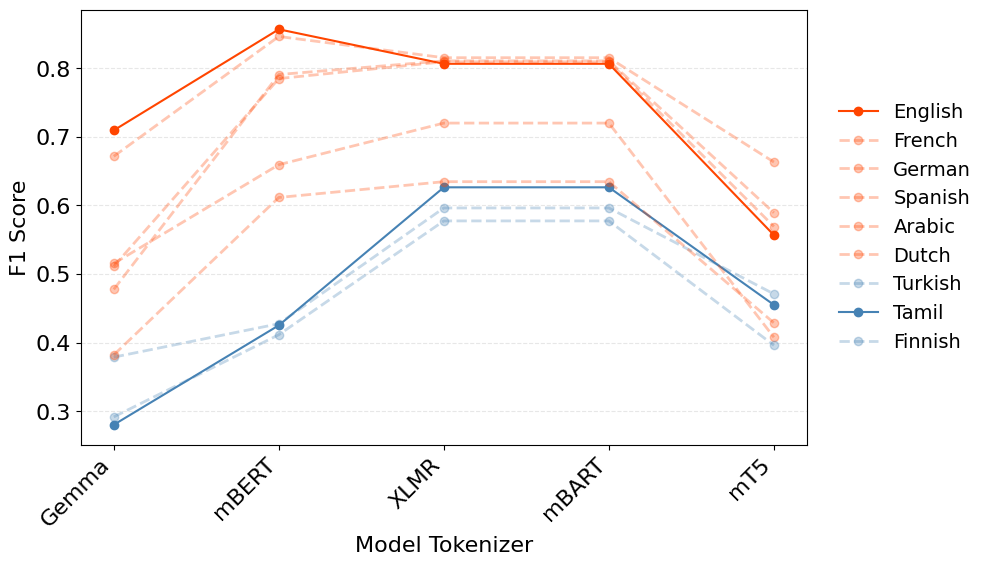

In [8]:
def Plot_Morphological_Alignment(dataframe, Title):
    highlight_langs = ['English', 'Tamil']
    
    plt.figure(figsize=(10, 5))
    for lang in dataframe.index:
        if lang in ['Tamil', 'Finnish', 'Turkish']:
            if lang == 'Tamil':
                plt.plot(tokenizer_cols, dataframe.loc[lang], marker='o', label=lang, color='steelblue')
            else:
                plt.plot(tokenizer_cols, dataframe.loc[lang], marker='o', label=lang, color='steelblue', alpha=0.3, linestyle='--', linewidth=2)
        else:
            if lang == 'English':
                plt.plot(tokenizer_cols, dataframe.loc[lang], marker='o', label=lang, color='orangered')
            else:
                plt.plot(tokenizer_cols, dataframe.loc[lang], marker='o', label=lang, color='orangered', alpha=0.3, linestyle='--', linewidth=2)

    plt.xlabel("Model Tokenizer", fontsize=16)
    plt.ylabel(Title, fontsize=16)
    
    plt.xticks(fontsize=16, rotation=45, ha='right')
    plt.yticks(fontsize=16)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    scores = [dataframe.loc[label]['mBERT'] for label in labels]
    sorted_items = sorted(zip(scores, handles, labels), reverse=True)
    sorted_handles, sorted_labels = zip(*[(h, l) for _, h, l in sorted_items])
    
    plt.legend(sorted_handles, sorted_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.savefig('MorphologyPlot.jpg', dpi=1000, bbox_inches='tight')
    plt.show()

Plot_Morphological_Alignment(f1_df, "F1 Score")

## Evaluate on Custom Dataset

In [9]:
df = pd.read_csv("/mnt/vast-react/projects/react_ag_beinborn_students/u17842/Datasets/Single_Suffix_Verb_Noun_Chunks/SegmentorTrainingCorpus.csv", index_col=None)
df.head()

,Word,Morphology,Altered Morphology,Root Suffix Morphology,Root Suffix Morphology Altered
0,பட்டுச்சேலைகள்,பட்டுச்சேலை கள்,பட்டுச்சேலை கள்,பட்டுச்சேலை கள்,பட்டுச்சேலை கள்
1,பட்டுச்சேலையின்,பட்டுச்சேலை யின்,பட்டுச்சேலை ய ின்,பட்டுச்சேலை யின்,பட்டுச்சேலை யின்
2,பட்டுச்சேலைகளின்,பட்டுச்சேலை க ளின்,பட்டுச்சேலை கள ின்,பட்டுச்சேலை களின்,பட்டுச்சேலை களின்
3,பட்டுச்சேலையுடன்,பட்டுச்சேலை யுடன்,பட்டுச்சேலை ய ுடன்,பட்டுச்சேலை யுடன்,பட்டுச்சேலை யுடன்
4,பட்டுச்சேலையில்,பட்டுச்சேலை யில்,பட்டுச்சேலை ய ில்,பட்டுச்சேலை யில்,பட்டுச்சேலை யில்


In [10]:
Custom_Morph_Dataset = df[['Word', 'Root Suffix Morphology Altered']].copy()
Custom_Morph_Dataset = Custom_Morph_Dataset.rename(columns={'Word':'wordform'})
Custom_Morph_Dataset['stem'] = Custom_Morph_Dataset['Root Suffix Morphology Altered'].apply(lambda x: x.strip().split()[0])
Custom_Morph_Dataset['following_part'] = Custom_Morph_Dataset['Root Suffix Morphology Altered'].apply(lambda x: x.strip().split()[-1])
Custom_Morph_Dataset = Custom_Morph_Dataset.drop({'Root Suffix Morphology Altered'}, axis=1)
Custom_Dataset = Custom_Morph_Dataset.copy()
Custom_Dataset.shape

(503292, 3)

In [11]:
tokenization_function(Custom_Dataset)

precision_table = {}
recall_table = {}
f1_table = {}
accuracy_table = {}

morph_alignment = compute_morphological_alignment(Custom_Dataset, tokenizer_cols)
recall_table['tamil'] = {tok: morph_alignment.loc[tok,"Recall"] for tok in tokenizer_cols}
precision_table['tamil'] = {tok: morph_alignment.loc[tok,"Precision"] for tok in tokenizer_cols}
f1_table['tamil'] = {tok: morph_alignment.loc[tok,"F1 Score"] for tok in tokenizer_cols}
accuracy_table['tamil'] = {tok: morph_alignment.loc[tok,"Accuracy"] for tok in tokenizer_cols}

recall_df = pd.DataFrame.from_dict(recall_table, orient="index")
precision_df = pd.DataFrame.from_dict(precision_table, orient="index")
f1_df = pd.DataFrame.from_dict(f1_table, orient="index")
accuracy_df = pd.DataFrame.from_dict(accuracy_table, orient="index")

In [12]:
accuracy_df.head()

,Gemma,mBERT,XLMR,mBART,mT5
tamil,0.377701,0.604617,0.573303,0.573303,0.492633


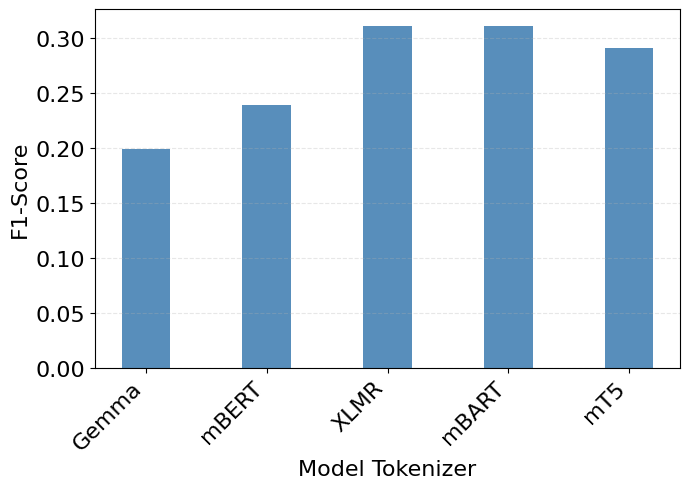

In [13]:
plt.figure(figsize=(7, 5))
plt.bar(tokenizer_cols, f1_df.loc['tamil'], width = 0.40, color='steelblue', alpha=0.9)
plt.ylabel('F1-Score', fontsize=16)
plt.xlabel('Model Tokenizer', fontsize=16)
plt.xticks(fontsize=16, rotation=45, ha='right')
plt.yticks(fontsize=16)
plt.tight_layout()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.savefig('MorphologyAlignmentCustomData.jpg', dpi=1000, bbox_inches='tight')
plt.show()


## Evaluate Morphological Tokenizers

In [14]:
bbpe3, unigram3, wordpiece3 = get_morphological_tokenizers("3", "IndicCorpus")
bbpe5, unigram5, wordpiece5 = get_morphological_tokenizers("5", "IndicCorpus")
bbpe8, unigram8, wordpiece8 = get_morphological_tokenizers("8", "IndicCorpus")
bbpe10, unigram10, wordpiece10 = get_morphological_tokenizers("10", "IndicCorpus")
bbpe20, unigram20, wordpiece20 = get_morphological_tokenizers("20", "IndicCorpus")
bbpe32, unigram32, wordpiece32 = get_morphological_tokenizers("32", "IndicCorpus")

CSS_bbpe3, CSS_unigram3, CSS_wordpiece3 = get_morphological_tokenizers("3", "CSSIndicCorpus")
CSS_bbpe5, CSS_unigram5, CSS_wordpiece5 = get_morphological_tokenizers("5", "CSSIndicCorpus")
CSS_bbpe8, CSS_unigram8, CSS_wordpiece8 = get_morphological_tokenizers("8", "CSSIndicCorpus")
CSS_bbpe10, CSS_unigram10, CSS_wordpiece10 = get_morphological_tokenizers("10", "CSSIndicCorpus")
CSS_bbpe20, CSS_unigram20, CSS_wordpiece20 = get_morphological_tokenizers("20", "CSSIndicCorpus")
CSS_bbpe32, CSS_unigram32, CSS_wordpiece32 = get_morphological_tokenizers("32", "CSSIndicCorpus")

SSS_bbpe3, SSS_unigram3, SSS_wordpiece3 = get_morphological_tokenizers("3", "SSSIndicCorpus")
SSS_bbpe5, SSS_unigram5, SSS_wordpiece5 = get_morphological_tokenizers("5", "SSSIndicCorpus")
SSS_bbpe8, SSS_unigram8, SSS_wordpiece8 = get_morphological_tokenizers("8", "SSSIndicCorpus")
SSS_bbpe10, SSS_unigram10, SSS_wordpiece10 = get_morphological_tokenizers("10", "SSSIndicCorpus")
SSS_bbpe20, SSS_unigram20, SSS_wordpiece20 = get_morphological_tokenizers("20", "SSSIndicCorpus")
SSS_bbpe32, SSS_unigram32, SSS_wordpiece32 = get_morphological_tokenizers("32", "SSSIndicCorpus")

In [15]:
BBPE_Indic_Dict = {
    "3K":bbpe3, "5K":bbpe5, "8K":bbpe8, "10K":bbpe10, "20K":bbpe20, "32K":bbpe32,
}
Unigram_Indic_Dict = {
    "3K":unigram3, "5K":unigram5, "8K":unigram8, "10K":unigram10, "20K":unigram20, "32K":unigram32,
}
Wordpiece_Indic_Dict = {
    "3K":wordpiece3, "5K":wordpiece5, "8K":wordpiece8, "10K":wordpiece10, "20K":wordpiece20, "32K":wordpiece32,
}

BBPE_SSS_Indic_Dict = {
    "3K":SSS_bbpe3, "5K":SSS_bbpe5, "8K":SSS_bbpe8, "10K":SSS_bbpe10, "20K":SSS_bbpe20, "32K":SSS_bbpe32,
}
Unigram_SSS_Indic_Dict = {
    "3K":SSS_unigram3, "5K":SSS_unigram5, "8K":SSS_unigram8, "10K":SSS_unigram10, "20K":SSS_unigram20, "32K":SSS_unigram32,
}
Wordpiece_SSS_Indic_Dict = {
    "3K":SSS_wordpiece3, "5K":SSS_wordpiece5, "8K":SSS_wordpiece8, "10K":SSS_wordpiece10, "20K":SSS_wordpiece20, "32K":SSS_wordpiece32,
}

BBPE_CSS_Indic_Dict = {
    "3K":CSS_bbpe3, "5K":CSS_bbpe5, "8K":CSS_bbpe8, "10K":CSS_bbpe10, "20K":CSS_bbpe20, "32K":CSS_bbpe32,
}
Unigram_CSS_Indic_Dict = {
    "3K":CSS_unigram3, "5K":CSS_unigram5, "8K":CSS_unigram8, "10K":CSS_unigram10, "20K":CSS_unigram20, "32K":CSS_unigram32,
}
Wordpiece_CSS_Indic_Dict = {
    "3K":CSS_wordpiece3, "5K":CSS_wordpiece5, "8K":CSS_wordpiece8, "10K":CSS_wordpiece10, "20K":CSS_wordpiece20, "32K":CSS_wordpiece32,
}

    
def apply_tokenizer_dict(df, tokenizers, word_column="wordform", is_wordpiece=False):
    if is_wordpiece:
        for label, tok in tokenizers.items():
            df[label] = df[word_column].apply(lambda w: tok.encode(w,add_special_tokens=False).tokens).apply(remove_bert_underscore)
    else:
        for label, tok in tokenizers.items():
            df[label] = df[word_column].apply(lambda w: tok.encode(w, out_type=str)).apply(remove_sentencepiece_underscore)

IndicBBPETokenized, IndicUnigramTokenized, IndicWordpieceTokenized = Morph_data_Tamil.copy(),Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
apply_tokenizer_dict(IndicBBPETokenized, BBPE_Indic_Dict)
apply_tokenizer_dict(IndicUnigramTokenized, Unigram_Indic_Dict)
apply_tokenizer_dict(IndicWordpieceTokenized, Wordpiece_Indic_Dict, is_wordpiece=True)

SSSBBPETokenized, SSSUnigramTokenized, SSSWordpieceTokenized = Morph_data_Tamil.copy(),Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
apply_tokenizer_dict(SSSBBPETokenized, BBPE_SSS_Indic_Dict)
apply_tokenizer_dict(SSSUnigramTokenized, Unigram_SSS_Indic_Dict)
apply_tokenizer_dict(SSSWordpieceTokenized, Wordpiece_SSS_Indic_Dict, is_wordpiece=True)

CSSBBPETokenized, CSSUnigramTokenized, CSSWordpieceTokenized = Morph_data_Tamil.copy(),Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
apply_tokenizer_dict(CSSBBPETokenized, BBPE_CSS_Indic_Dict)
apply_tokenizer_dict(CSSUnigramTokenized, Unigram_CSS_Indic_Dict)
apply_tokenizer_dict(CSSWordpieceTokenized, Wordpiece_CSS_Indic_Dict, is_wordpiece=True)

In [16]:
tokenizer_cols = ["3K","5K","8K","10K","20K","32K"]

def Morphological_analysis(dataframes, tokenizer_cols=tokenizer_cols):
    tokenizer_cols = sorted(tokenizer_cols, key=lambda x: int(x.replace("K","")))
    
    f1_table = {}
    accuracy_table = {}
    
    for lang, df in dataframes.items():
        morph_alignment = compute_morphological_alignment(df, tokenizer_cols)
        f1_table[lang] = {
            tok: pd.to_numeric(morph_alignment.loc[tok, "F1 Score"], errors="coerce")
            for tok in tokenizer_cols
        }

        accuracy_table[lang] = {
            tok: pd.to_numeric(morph_alignment.loc[tok, "Accuracy"], errors="coerce")
            for tok in tokenizer_cols
        }

    f1_df = pd.DataFrame.from_dict(f1_table, orient="index")
    accuracy_df = pd.DataFrame.from_dict(accuracy_table, orient="index")
    f1_df = f1_df[tokenizer_cols].apply(pd.to_numeric, errors="coerce")
    accuracy_df = accuracy_df[tokenizer_cols].apply(pd.to_numeric, errors="coerce")

    return f1_df, accuracy_df

In [17]:
f1_Dataframes = {
    "Byte-level BPE (Base)": IndicBBPETokenized,
    "UnigramLM (Base)": IndicUnigramTokenized,
    "Wordpiece (Base)": IndicWordpieceTokenized,

    "Byte-level BPE (SSS)": SSSBBPETokenized,
    "UnigramLM (SSS)": SSSUnigramTokenized,
    "Wordpiece (SSS)": SSSWordpieceTokenized,

    "Byte-level BPE (CSS)": CSSBBPETokenized,
    "UnigramLM (CSS)": CSSUnigramTokenized,
    "Wordpiece (CSS)": CSSWordpieceTokenized,
}

f1_df, accuracy_df = Morphological_analysis(f1_Dataframes)
f1_df.head()

,3K,5K,8K,10K,20K,32K
Byte-level BPE (Base),0.575410,0.650669,0.692551,0.707972,0.770897,0.794777
UnigramLM (Base),0.666544,0.703954,0.731690,0.744014,0.776606,0.794510
Wordpiece (Base),0.599857,0.647859,0.698308,0.717327,0.766696,0.784434
Byte-level BPE (SSS),0.576854,0.622899,0.659687,0.674617,0.724561,0.744736
UnigramLM (SSS),0.689355,0.724400,0.750313,0.757773,0.788772,0.793087


In [18]:
def plot_compare_groups(base_df, other_df, tokenizer_cols, other_label, plot_name):
    """
    base_df: dataframe containing Base results (index = tokenizers)
    other_df: dataframe containing SSS or CSS results
    """

    # keep only existing vocabulary columns (avoid KeyErrors)
    existing_cols = [c for c in tokenizer_cols if c in base_df.columns]

    base_df = base_df[existing_cols].apply(pd.to_numeric, errors="coerce")
    other_df = other_df[existing_cols].apply(pd.to_numeric, errors="coerce")

    ordered_cols = sorted(existing_cols, key=lambda x: int(x.replace("K", "")))

    marker_map = {
        "Base": "o",
        other_label: "s" if other_label == "SSS" else "^"
    }

    plt.figure(figsize=(10, 6))

    # ---------- Base ----------
    for tokenizer_name in base_df.index:
        plt.plot(
            ordered_cols,
            base_df.loc[tokenizer_name, ordered_cols].values,
            marker=marker_map["Base"],
            linewidth=2,
            label=f"{tokenizer_name}"
        )

    # ---------- Other (SSS/CSS) ----------
    for tokenizer_name in other_df.index:
        plt.plot(
            ordered_cols,
            other_df.loc[tokenizer_name, ordered_cols].values,
            marker=marker_map[other_label],
            linestyle="--",
            linewidth=2,
            label=f"{tokenizer_name}"
        )

    plt.xlabel("Vocabulary Size", fontsize=16)
    plt.ylabel("F1-Score", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(8))
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(len(ordered_cols)))
    plt.grid(True, linestyle="--", alpha=0.4)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        fontsize=14
    )
    plt.tight_layout()
    plt.savefig(plot_name, dpi=1000, bbox_inches='tight')
    plt.show()


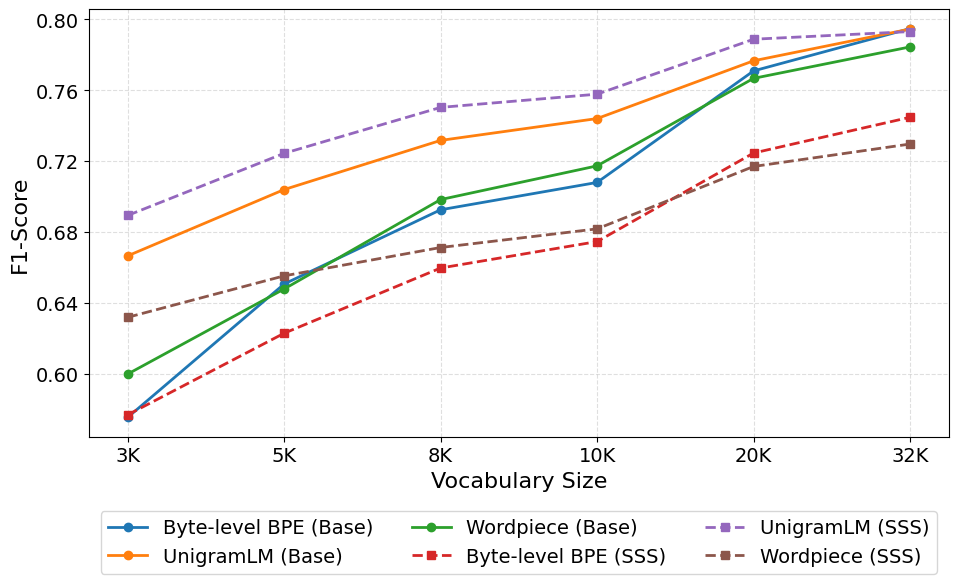

In [19]:
plot_compare_groups(
    base_df=f1_df.loc[f1_df.index.str.contains(r"\(Base\)")],
    other_df=f1_df.loc[f1_df.index.str.contains(r"\(SSS\)")],
    tokenizer_cols=tokenizer_cols,
    other_label="SSS",
    plot_name="SSS_vs_Base.jpg"
)


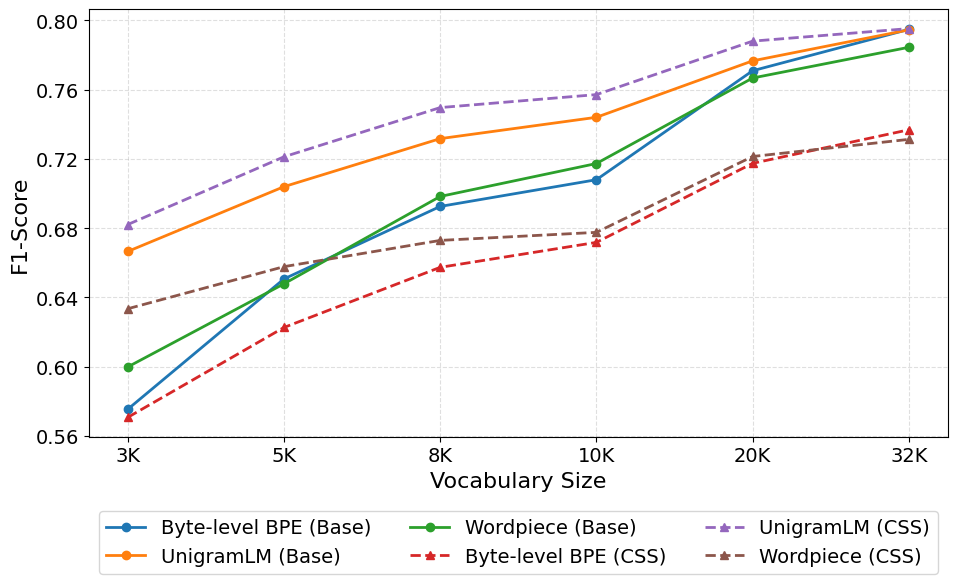

In [20]:
plot_compare_groups(
    base_df=f1_df.loc[f1_df.index.str.contains(r"\(Base\)")],
    other_df=f1_df.loc[f1_df.index.str.contains(r"\(CSS\)")],
    tokenizer_cols=tokenizer_cols,
    other_label="CSS",
    plot_name="CSS_vs_Base.jpg"
)


## Evaluating fertility

In [21]:
tokenizer_cols = ["3K","5K","8K","10K","20K","32K"]

def calculate_fertility(dataframes, tokenizer_cols = tokenizer_cols):
    fertility_table = {}
    for scheme, df in dataframes.items():
        for columns in tokenizer_cols:
            df[f"{columns}_Length"] = df[columns].apply(lambda x: len(x))

        fertility_table[scheme] = {tok: df[f"{tok}_Length"].mean() for tok in tokenizer_cols}

    fertility_df = pd.DataFrame.from_dict(fertility_table, orient="index")
    return fertility_df

In [23]:
CustomBBPETokenized, CustomUnigramTokenized, CustomWordpieceTokenized = Custom_Dataset[:15000].copy(),Custom_Dataset[:15000].copy(), Custom_Dataset[:15000].copy()
apply_tokenizer_dict(CustomBBPETokenized, BBPE_Indic_Dict)
apply_tokenizer_dict(CustomUnigramTokenized, Unigram_Indic_Dict)
apply_tokenizer_dict(CustomWordpieceTokenized, Wordpiece_Indic_Dict, is_wordpiece=True)

CustomSSSBBPETokenized, CustomSSSUnigramTokenized, CustomSSSWordpieceTokenized = Custom_Dataset[:15000].copy(),Custom_Dataset[:15000].copy(), Custom_Dataset[:15000].copy()
apply_tokenizer_dict(CustomSSSBBPETokenized, BBPE_SSS_Indic_Dict)
apply_tokenizer_dict(CustomSSSUnigramTokenized, Unigram_SSS_Indic_Dict)
apply_tokenizer_dict(CustomSSSWordpieceTokenized, Wordpiece_SSS_Indic_Dict, is_wordpiece=True)

CustomCSSBBPETokenized, CustomCSSUnigramTokenized, CustomCSSWordpieceTokenized = Custom_Dataset[:15000].copy(),Custom_Dataset[:15000].copy(), Custom_Dataset[:15000].copy()
apply_tokenizer_dict(CustomCSSBBPETokenized, BBPE_CSS_Indic_Dict)
apply_tokenizer_dict(CustomCSSUnigramTokenized, Unigram_CSS_Indic_Dict)
apply_tokenizer_dict(CustomCSSWordpieceTokenized, Wordpiece_CSS_Indic_Dict, is_wordpiece=True)

In [24]:
Fertility_Dataframes = {
    "Byte-level BPE (Base)": CustomBBPETokenized,
    "UnigramLM (Base)": CustomUnigramTokenized,
    "Wordpiece (Base)": CustomWordpieceTokenized,

    "Byte-level BPE (SSS)": CustomSSSBBPETokenized,
    "UnigramLM (SSS)": CustomSSSUnigramTokenized,
    "Wordpiece (SSS)": CustomSSSWordpieceTokenized,

    "Byte-level BPE (CSS)": CustomCSSBBPETokenized,
    "UnigramLM (CSS)": CustomCSSUnigramTokenized,
    "Wordpiece (CSS)": CustomCSSWordpieceTokenized,
}

fertility_df = calculate_fertility(Fertility_Dataframes)
fertility_df.head(10)

,3K,5K,8K,10K,20K,32K
Byte-level BPE (Base),3.911800,3.556600,3.285867,3.169067,2.832800,2.639000
UnigramLM (Base),3.911200,3.614000,3.320933,3.195467,2.806533,2.595333
Wordpiece (Base),3.874267,3.532867,3.273733,3.157933,2.805133,2.615600
Byte-level BPE (SSS),4.362800,3.983000,3.632533,3.484200,3.060467,2.823667
UnigramLM (SSS),4.337600,3.868733,3.489400,3.328200,2.883133,2.662000
Wordpiece (SSS),4.218600,3.855333,3.539267,3.400933,2.964333,2.726333
Byte-level BPE (CSS),4.245800,3.934467,3.638733,3.499933,3.081800,2.840400
UnigramLM (CSS),4.264933,3.827600,3.483667,3.326600,2.865733,2.670133
Wordpiece (CSS),4.131267,3.809733,3.514867,3.397067,2.969667,2.743800


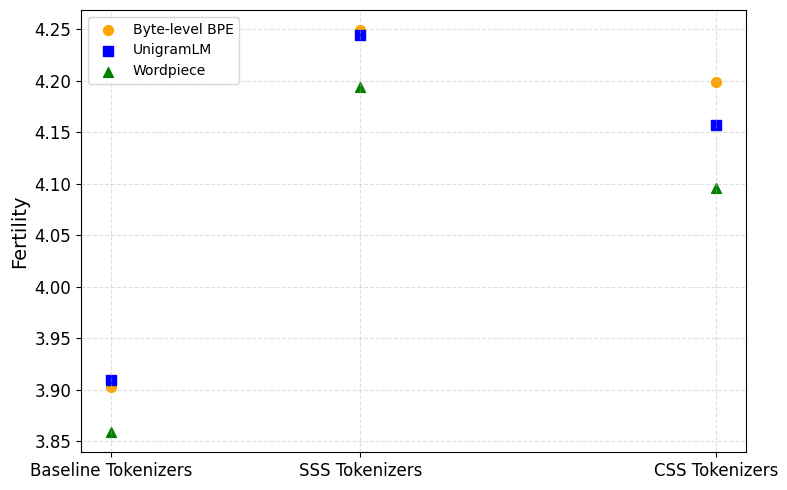

In [25]:
x_labels = ["Baseline Tokenizers", "SSS Tokenizers", "CSS Tokenizers"]
bbpe = [3.9024, 4.2493, 4.1989]
unigram = [3.9091, 4.2448, 4.1569]
wordpiece = [3.8586, 4.1941, 4.0959]

x_pos = np.arange(len(x_labels))
x_pos_shifted = [x_pos[0] + 0.3, x_pos[1], x_pos[2]]

plt.figure(figsize=(8,5))

# Scatter points
plt.scatter(x_pos_shifted, bbpe, label="Byte-level BPE", color="orange", marker="o", s=50)
plt.scatter(x_pos_shifted, unigram, label="UnigramLM", color="blue", marker="s", s=50)
plt.scatter(x_pos_shifted, wordpiece, label="Wordpiece", color="green", marker="^", s=50)

plt.ylabel("Fertility", fontsize=14)
plt.xticks(x_pos_shifted, x_labels, fontsize=12)
plt.yticks(fontsize=12)

plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("MorphFertility.jpg", dpi=1000, bbox_inches='tight')
plt.show()


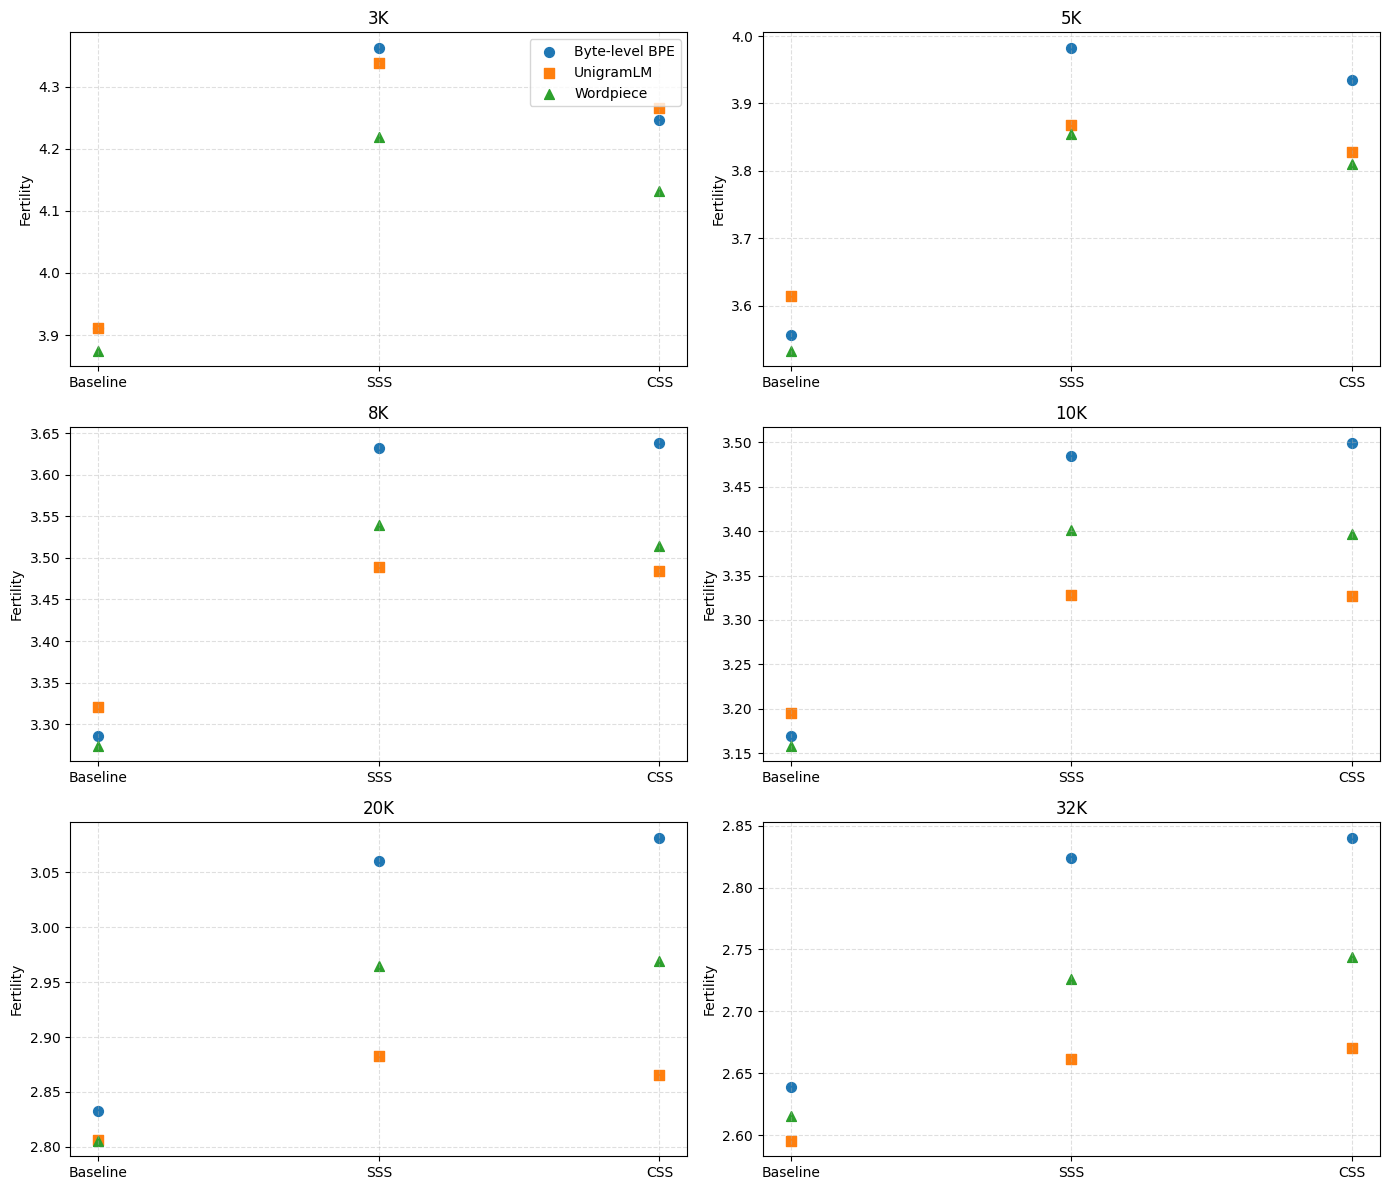

In [26]:
vocab_sizes = fertility_df.columns.tolist()

# group rows into Baseline / SSS / CSS groups
baseline = fertility_df.iloc[0:3]
sss = fertility_df.iloc[3:6]
css = fertility_df.iloc[6:9]

x_labels = ["Baseline", "SSS", "CSS"]
x_pos = np.arange(3)

plt.figure(figsize=(14, 12))

for i, vocab in enumerate(vocab_sizes):
    ax = plt.subplot(3, 2, i+1)

    bbpe = [baseline.loc["Byte-level BPE (Base)", vocab],
            sss.loc["Byte-level BPE (SSS)", vocab],
            css.loc["Byte-level BPE (CSS)", vocab]]

    unigram = [baseline.loc["UnigramLM (Base)", vocab],
               sss.loc["UnigramLM (SSS)", vocab],
               css.loc["UnigramLM (CSS)", vocab]]

    wordpiece = [baseline.loc["Wordpiece (Base)", vocab],
                 sss.loc["Wordpiece (SSS)", vocab],
                 css.loc["Wordpiece (CSS)", vocab]]

    # shift x positions just like your reference plot
    x_shifted = [x_pos[0] + 0.3, x_pos[1], x_pos[2] - 0.3]

    ax.scatter(x_shifted, bbpe, marker="o", s=50, label="Byte-level BPE")
    ax.scatter(x_shifted, unigram, marker="s", s=50, label="UnigramLM")
    ax.scatter(x_shifted, wordpiece, marker="^", s=50, label="Wordpiece")

    ax.set_title(vocab)
    ax.set_xticks(x_shifted)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel("Fertility")
    ax.grid(True, linestyle="--", alpha=0.4)

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.savefig("MorphFertilityAllSizes.jpg", dpi=1000, bbox_inches='tight')
plt.show()

## Evaluating Compression Ratio

In [27]:
import random

sentences = []
with open('/mnt/vast-react/projects/react_ag_beinborn_students/u17842/Datasets/CleanedWikiCorpus.txt', 'r', encoding='utf-8') as fin:
    sentences = fin.readlines()
print(len(sentences))

Evaluation_Sample = random.sample(sentences, 10000)

2997493


In [28]:
def compression_ratio(sentence, tokenizer):
    orig_len = len(sentence)
    tokenized_len = len(tokenizer.encode(sentence))
    return orig_len / tokenized_len if tokenized_len > 0 else 0


In [29]:
all_tokenizer_groups = {
    "Byte-level BPE (Base)": BBPE_Indic_Dict,
    "Unigram (Base)": Unigram_Indic_Dict,
    "Wordpiece (Base)": Wordpiece_Indic_Dict,

    "Byte-level BPE (SSS)": BBPE_SSS_Indic_Dict,
    "Unigram (SSS)": Unigram_SSS_Indic_Dict,
    "Wordpiece (SSS)": Wordpiece_SSS_Indic_Dict,

    "Byte-level BPE (CSS)": BBPE_CSS_Indic_Dict,
    "Unigram (CSS)": Unigram_CSS_Indic_Dict,
    "Wordpiece (CSS)": Wordpiece_CSS_Indic_Dict,
}


In [30]:
results = {}

for group_name, group_dict in all_tokenizer_groups.items():
    results[group_name] = {}
    for size, tokenizer in group_dict.items():
        ratios = [compression_ratio(s, tokenizer) for s in Evaluation_Sample]
        avg_ratio = sum(ratios) / len(ratios)
        results[group_name][size] = avg_ratio

for group_name, group_results in results.items():
    print(group_name)
    for size, ratio in group_results.items():
        print(f"  {size}: {ratio:.3f}")
    print()


Byte-level BPE (Base)
  3K: 3.541
  5K: 4.034
  8K: 4.463
  10K: 4.672
  20K: 5.301
  32K: 5.667

Unigram (Base)
  3K: 3.730
  5K: 4.177
  8K: 4.591
  10K: 4.775
  20K: 5.365
  32K: 5.691

Wordpiece (Base)
  3K: 3.150
  5K: 3.534
  8K: 3.864
  10K: 4.029
  20K: 4.513
  32K: 4.783

Byte-level BPE (SSS)
  3K: 3.401
  5K: 3.819
  8K: 4.203
  10K: 4.378
  20K: 4.912
  32K: 5.233

Unigram (SSS)
  3K: 3.587
  5K: 4.001
  8K: 4.384
  10K: 4.530
  20K: 5.007
  32K: 5.313

Wordpiece (SSS)
  3K: 3.073
  5K: 3.414
  8K: 3.696
  10K: 3.832
  20K: 4.248
  32K: 4.508

Byte-level BPE (CSS)
  3K: 3.395
  5K: 3.811
  8K: 4.189
  10K: 4.357
  20K: 4.907
  32K: 5.235

Unigram (CSS)
  3K: 3.584
  5K: 3.991
  8K: 4.367
  10K: 4.517
  20K: 5.005
  32K: 5.303

Wordpiece (CSS)
  3K: 3.057
  5K: 3.404
  8K: 3.689
  10K: 3.822
  20K: 4.241
  32K: 4.506

